In [52]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import nashpy as nash
import os
import re

In [35]:
# https://dandrake.livejournal.com/83095.html
def compositions(n,k):
  if n < 0 or k < 0:
    return
  elif k == 0:
    # the empty sum, by convention, is zero, so only return something if
    # n is zero
    if n == 0:
      yield []
    return
  elif k == 1:
    yield [n]
    return
  else:
    for i in range(0,n+1):
      for comp in compositions(n-i,k-1):
        yield [i] + comp
        
# https://stackoverflow.com/questions/1806278/convert-fraction-to-float        
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        if type(frac_str) == bytes:
            frac_str = frac_str.decode()
        try:
            num, denom = frac_str.split('/')
        except ValueError:
            return None
        try:
            leading, num = num.split(' ')
        except ValueError:
            return float(num) / float(denom)        
        if float(leading) < 0:
            sign_mult = -1
        else:
            sign_mult = 1
        return float(leading) + sign_mult * (float(num) / float(denom))

In [84]:
def make_nfg_file(spaces, A, D):
    defender = np.array([c for c in compositions(D,spaces)])
    attacker = np.array([c for c in compositions(A, spaces)])

    M = np.zeros((len(defender),len(attacker)), dtype=int)
    for i in range(len(defender)):
        for j in range(len(attacker)):
            M[i,j] = 1 if not np.any((defender[i,:] - attacker[j,:]) < 0) else 0
            print(i,j,M[i,j],defender[i,:], attacker[j,:])


    directory = "games"
    filename = "chipGame_n{}_A{}_D{}.nfg".format(spaces, A, D)
    # array sorcery
    zerosum_form = np.vstack((M.T.flatten(),-M.T.flatten())).reshape((-1,),order='F')
    with open(os.path.join(directory,filename),'w') as file:
        file.writelines('NFG 1 R "Chip Game"\n') 
        file.writelines(r'{ "Defender" "Attacker" } ' + '{{ {} {} }}\n'.format(len(defender),len(attacker)))
        np.savetxt(file, zerosum_form, fmt='%i')
        
    return M

def get_results(spaces, A, D):
    game = 'chipGame_n{}_A{}_D{}'.format(spaces,A,D)

    filename = game + '.nfg'
    directory = 'games'
    normalFormMatrix = np.loadtxt(os.path.join(directory, filename), skiprows=2)
    with open(os.path.join(directory, filename), 'r') as file:
        file.readline()
        header = file.readline()
        pattern = re.compile(r'{.*?} { (\d*) (\d*) }.*?')
        nums = pattern.findall(header)[0]
        defender_strategies, attacker_strategies = map(int, nums)

    M = normalFormMatrix[::2].reshape((defender_strategies, attacker_strategies))

    filename = game + '.out'
    converters = {i:convert_to_float for i in range(defender_strategies+attacker_strategies+1)}
    equilibrium = np.genfromtxt(os.path.join(directory, filename), delimiter=',', 
                                usecols=range(1,1+defender_strategies+attacker_strategies),
                                converters =  converters)

    defenderStrat = equilibrium[0:defender_strategies]
    attackerStrat = equilibrium[defender_strategies:]

    expected_value = defenderStrat@M@attackerStrat
    
    return attackerStrat, defenderStrat, expected_value, M
    

In [68]:
# create nfg files
spaces = 3
for A in range(max_attack):
    for D in range(max_defense):
        make_nfg_file(spaces, A, D)

In [72]:
max_attack = 9
max_defense = 9
spaces = 3
defender_wins = np.zeros((max_defense, max_attack))

for A in range(max_attack):
    for D in range(max_defense):
        attackerStrat, defenderStrat, expected_value, M = get_results(spaces, A, D)
        defender_wins[A,D] = expected_value

<IPython.core.display.Javascript object>


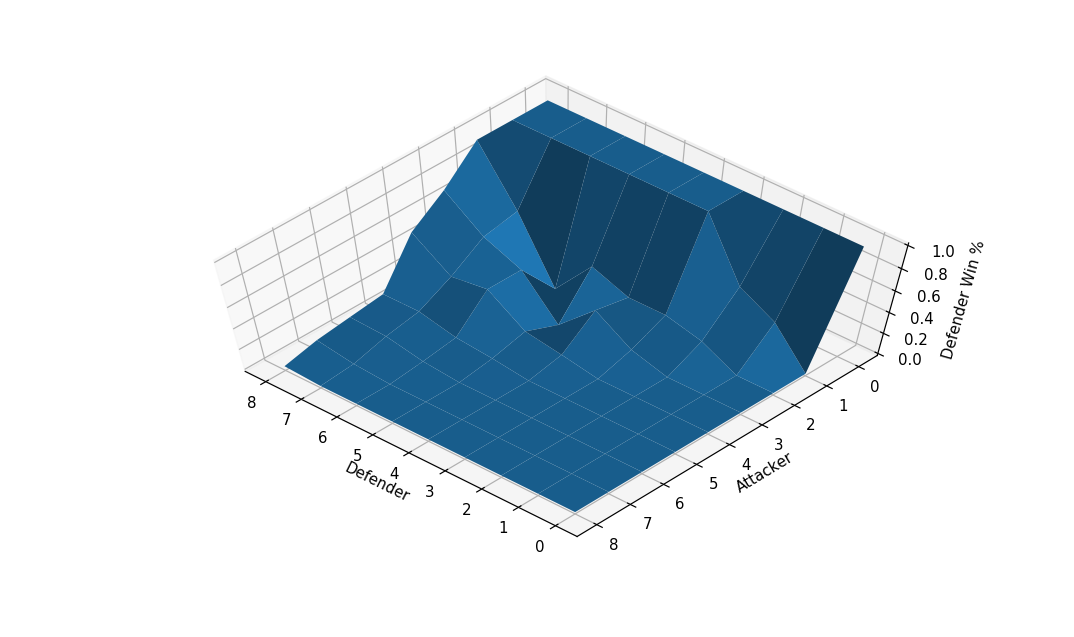

Text(0.5,0,'Defender')

In [70]:
fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(0, max_defense)
Y = np.arange(0, max_attack)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, defender_wins)
ax.set_zlabel("Defender Win %")
ax.set_ylabel("Attacker")
ax.set_xlabel("Defender")

In [79]:
a,d,e, M = get_results(3,2,4)


In [74]:
d

array([0.5, 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. ])

In [75]:
e

0.25

In [76]:
a

array([0.5, 0.5, 0. , 0. , 0. , 0. ])

In [100]:
M.T

array([[1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.]])

In [85]:
x = make_nfg_file(3,2,4)

0 0 1 [0 0 4] [0 0 2]
0 1 0 [0 0 4] [0 1 1]
0 2 0 [0 0 4] [0 2 0]
0 3 0 [0 0 4] [1 0 1]
0 4 0 [0 0 4] [1 1 0]
0 5 0 [0 0 4] [2 0 0]
1 0 1 [0 1 3] [0 0 2]
1 1 1 [0 1 3] [0 1 1]
1 2 0 [0 1 3] [0 2 0]
1 3 0 [0 1 3] [1 0 1]
1 4 0 [0 1 3] [1 1 0]
1 5 0 [0 1 3] [2 0 0]
2 0 1 [0 2 2] [0 0 2]
2 1 1 [0 2 2] [0 1 1]
2 2 1 [0 2 2] [0 2 0]
2 3 0 [0 2 2] [1 0 1]
2 4 0 [0 2 2] [1 1 0]
2 5 0 [0 2 2] [2 0 0]
3 0 0 [0 3 1] [0 0 2]
3 1 1 [0 3 1] [0 1 1]
3 2 1 [0 3 1] [0 2 0]
3 3 0 [0 3 1] [1 0 1]
3 4 0 [0 3 1] [1 1 0]
3 5 0 [0 3 1] [2 0 0]
4 0 0 [0 4 0] [0 0 2]
4 1 0 [0 4 0] [0 1 1]
4 2 1 [0 4 0] [0 2 0]
4 3 0 [0 4 0] [1 0 1]
4 4 0 [0 4 0] [1 1 0]
4 5 0 [0 4 0] [2 0 0]
5 0 1 [1 0 3] [0 0 2]
5 1 0 [1 0 3] [0 1 1]
5 2 0 [1 0 3] [0 2 0]
5 3 1 [1 0 3] [1 0 1]
5 4 0 [1 0 3] [1 1 0]
5 5 0 [1 0 3] [2 0 0]
6 0 1 [1 1 2] [0 0 2]
6 1 1 [1 1 2] [0 1 1]
6 2 0 [1 1 2] [0 2 0]
6 3 1 [1 1 2] [1 0 1]
6 4 1 [1 1 2] [1 1 0]
6 5 0 [1 1 2] [2 0 0]
7 0 0 [1 2 1] [0 0 2]
7 1 1 [1 2 1] [0 1 1]
7 2 1 [1 2 1] [0 2 0]
7 3 1 [1 2

In [86]:
np.shape(x)

(15, 6)

In [91]:
converters = {i:convert_to_float for i in range(15+6+1)}
equilibrium = np.genfromtxt(os.path.join(directory, 'test.out'), delimiter=',', 
                                usecols=range(1,1+15+6),
                                converters =  converters)
defenderStrat = equilibrium[:,0:15]
attackerStrat = equilibrium[:,15:]


In [96]:
for i in range(len(defenderStrat)):
    print(i, defenderStrat[i,:]@M@attackerStrat[i,:])

0 0.25
1 0.25
2 0.25
3 0.125
4 0.0
5 0.25
6 0.25
7 0.75
8 0.5
9 0.25
10 0.0
11 0.0
12 0.25
13 0.25
14 0.25
15 0.5
16 0.5
17 0.0
18 0.0
19 0.0
20 0.5
21 0.5
22 0.5
23 0.375
24 0.25
25 0.25
26 0.25
27 0.0
28 0.125
29 0.25
30 0.25
31 0.5
32 0.25
33 0.375
34 0.25
35 0.25
36 0.5
37 0.75
38 0.75
39 0.5
40 0.0
41 0.25
42 0.25
43 0.5
44 0.5


In [98]:
print(defenderStrat[10,:])
print(attackerStrat[10,:])
print(M)

[0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]
[0.5 0.5 0.  0.  0.  0. ]
[[1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1. 0.]
 [0. 1. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [99]:
np.shape(M)

(15, 6)